In [1]:
# importing libs
import numpy as np
import tensorflow as tf
from keras.layers import Input, Dense, GaussianNoise
from keras.models import Model
from keras import regularizers
# from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.optimizers import SGD
import random as rn

In [2]:
# defining parameters
M = 4
k = np.log2(M)
k = int(k)
print ('M:',M,'k:',k)

M: 4 k: 2


In [3]:
#generating data of size N
N = 10000
label = np.random.randint(M,size=N)

In [4]:
# creating one hot encoded vectors
data = []
for i in label:
    temp = np.zeros(M)
    temp[i] = 1
    data.append(temp)

In [5]:
data = np.array(data)
print (data.shape)

(10000, 4)


In [6]:
temp_check = [17,23,45,67,89,96,72,250,350]
for i in temp_check:
    print(label[i],data[i])

3 [0. 0. 0. 1.]
2 [0. 0. 1. 0.]
2 [0. 0. 1. 0.]
2 [0. 0. 1. 0.]
0 [1. 0. 0. 0.]
0 [1. 0. 0. 0.]
1 [0. 1. 0. 0.]
3 [0. 0. 0. 1.]
3 [0. 0. 0. 1.]


In [7]:
R = 1
n_channel = 2
print (int(k/R))
input_signal = Input(shape=(M,))
encoded = Dense(M, activation='relu')(input_signal)
encoded1 = Dense(n_channel, activation='linear')(encoded)
encoded2 = BatchNormalization()(encoded1)

EbNo_train = 5.01187 #  coverted 7 db of EbNo
encoded3 = GaussianNoise(np.sqrt(1/(2*R*EbNo_train)))(encoded2)

decoded = Dense(M, activation='relu')(encoded3)
decoded1 = Dense(M, activation='softmax')(decoded)

autoencoder = Model(input_signal, decoded1)
#sgd = SGD(lr=0.001)
autoencoder.compile(optimizer='adam', loss='categorical_crossentropy')

2


In [8]:
print (autoencoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 4)                 20        
                                                                 
 dense_1 (Dense)             (None, 2)                 10        
                                                                 
 batch_normalization (BatchN  (None, 2)                8         
 ormalization)                                                   
                                                                 
 gaussian_noise (GaussianNoi  (None, 2)                0         
 se)                                                             
                                                                 
 dense_2 (Dense)             (None, 4)                 12    

In [9]:
N_val = 1500
val_label = np.random.randint(M,size=N_val)
val_data = []
for i in val_label:
    temp = np.zeros(M)
    temp[i] = 1
    val_data.append(temp)
val_data = np.array(val_data)

In [10]:
autoencoder.fit(data, data,
                epochs=100,
                batch_size=300,
                validation_data=(val_data, val_data))

Epoch 1/100
34/34 [==============================] - 3s 20ms/step - loss: 1.5632 - val_loss: 1.4031
Epoch 2/100
34/34 [==============================] - 0s 9ms/step - loss: 1.4040 - val_loss: 1.3443
Epoch 3/100
34/34 [==============================] - 0s 8ms/step - loss: 1.2569 - val_loss: 1.2500
Epoch 4/100
34/34 [==============================] - 0s 7ms/step - loss: 1.1276 - val_loss: 1.1455
Epoch 5/100
34/34 [==============================] - 0s 7ms/step - loss: 1.0152 - val_loss: 1.0352
Epoch 6/100
34/34 [==============================] - 0s 8ms/step - loss: 0.9140 - val_loss: 0.9337
Epoch 7/100
34/34 [==============================] - 0s 7ms/step - loss: 0.8160 - val_loss: 0.8311
Epoch 8/100
34/34 [==============================] - 0s 7ms/step - loss: 0.7181 - val_loss: 0.7278
Epoch 9/100
34/34 [==============================] - 0s 7ms/step - loss: 0.6240 - val_loss: 0.6264
Epoch 10/100
34/34 [==============================] - 0s 7ms/step - loss: 0.5385 - val_loss: 0.5233
Epoch 11

In [11]:
from keras.models import load_model
#autoencoder.save('4_7_symbol_autoencoder_v_best.model')

In [12]:
#autoencoder_loaded = load_model('4_7_symbol_autoencoder_v_best.model')

In [13]:
encoder = Model(input_signal, encoded2)

In [14]:
encoded_input = Input(shape=(n_channel,))

deco = autoencoder.layers[-2](encoded_input)
deco = autoencoder.layers[-1](deco)
# create the decoder model
decoder = Model(encoded_input, deco)

In [15]:
N = 45000
test_label = np.random.randint(M,size=N)
test_data = []

for i in test_label:
    temp = np.zeros(M)
    temp[i] = 1
    test_data.append(temp)
    
test_data = np.array(test_data)

In [16]:
temp_test = 6
print (test_data[temp_test][test_label[temp_test]],test_label[temp_test])

1.0 2


In [17]:
autoencoder

In [18]:
def frange(x, y, jump):
  while x < y:
    yield x
    x += jump

In [19]:
EbNodB_range = list(frange(-4,8.5,0.5))
ber = [None]*len(EbNodB_range)
for n in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[n]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    noise_mean = 0
    no_errors = 0
    nn = N
    noise = noise_std * np.random.randn(nn,n_channel)
    encoded_signal = encoder.predict(test_data) 
    final_signal = encoded_signal + noise
    pred_final_signal =  decoder.predict(final_signal)
    pred_output = np.argmax(pred_final_signal,axis=1)
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    ber[n] = no_errors / nn 
    print ('SNR:',EbNodB_range[n],'BER:',ber[n])

1407/1407 [==============================] - 4s 3ms/step
SNR: -4 BER: 0.09013333333333333
1407/1407 [==============================] - 5s 3ms/step
SNR: -3.5 BER: 0.07497777777777778
1407/1407 [==============================] - 5s 4ms/step
SNR: -3.0 BER: 0.05837777777777778
1407/1407 [==============================] - 6s 4ms/step
SNR: -2.5 BER: 0.04817777777777778
1407/1407 [==============================] - 5s 3ms/step
SNR: -2.0 BER: 0.034022222222222225
1407/1407 [==============================] - 4s 3ms/step
SNR: -1.5 BER: 0.024266666666666666
1407/1407 [==============================] - 4s 3ms/step
SNR: -1.0 BER: 0.018333333333333333
1407/1407 [==============================] - 5s 3ms/step
SNR: -0.5 BER: 0.01331111111111111
1407/1407 [==============================] - 4s 3ms/step
SNR: 0.0 BER: 0.008311111111111111
1407/1407 [==============================] - 5s 3ms/step
SNR: 0.5 BER: 0.006022222222222222
1407/1407 [==============================] - 4s 3ms/step
SNR: 1.0 BER: 0.003022

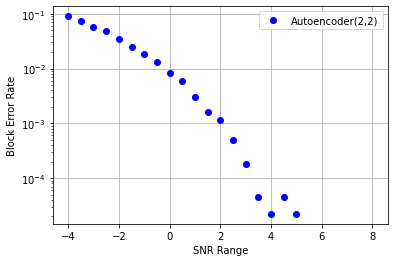

In [20]:
import matplotlib.pyplot as plt
plt.plot(EbNodB_range, ber, 'bo',label='Autoencoder(2,2)')
#plt.plot(list(EbNodB_range), ber_theory, 'ro-',label='BPSK BER')
plt.yscale('log')
plt.xlabel('SNR Range')
plt.ylabel('Block Error Rate')
plt.grid()
plt.legend(loc='upper right',ncol = 1)

In [22]:
plt.savefig('AutoEncoder_2_2_BER_matplotlib')
plt.show()

<Figure size 432x288 with 0 Axes>